# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

## Getting Started

In this project, I analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

The code block below load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. 

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, I will begin exploring the data through visualizations and code to understand how each feature is related to the others. I will examine a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which I will track through the course of this project.

The code block below examine the summary statistic  of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. 

In [2]:
# Display a description of the dataset
display(data.describe())


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


(0, 20000)

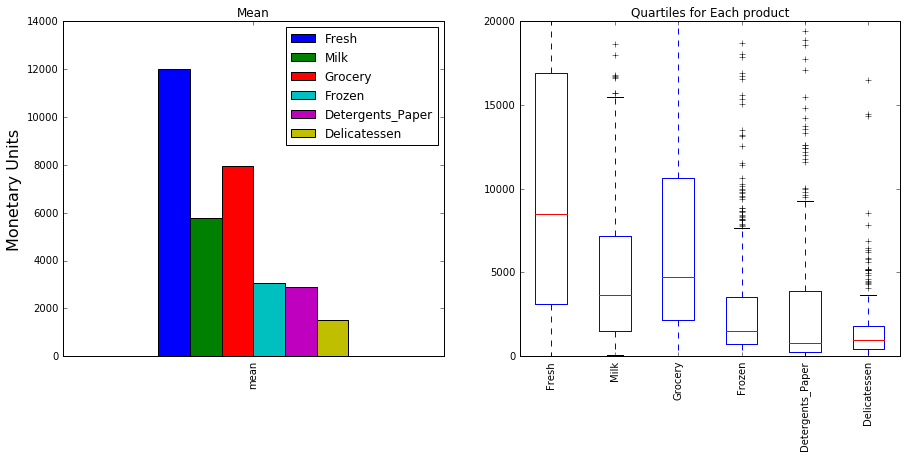

In [3]:
plt.rcParams['figure.figsize'] = (15, 6)

fig, axes = plt.subplots(nrows=1, ncols=2)

data.describe().loc[['mean'],:].plot(ax=axes[0],  kind = 'bar', title= 'Mean').\
set_ylabel('Monetary Units',{'fontsize': 16})

data.plot.box(ax=axes[1], rot=90, title= 'Quartiles for Each product').set_ylim(0,20000)


### Figures 1: population statistics, average median and quartiles for each product. 

### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, I choose **three** indices which will represent the customers to track. I choose customers that vary significantly from one another.

In [4]:
# Select three indices to sample from the dataset
indices = [0, 130, 427]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7149,2428,699,6316,395,911
2,31012,16687,5429,15082,439,1163


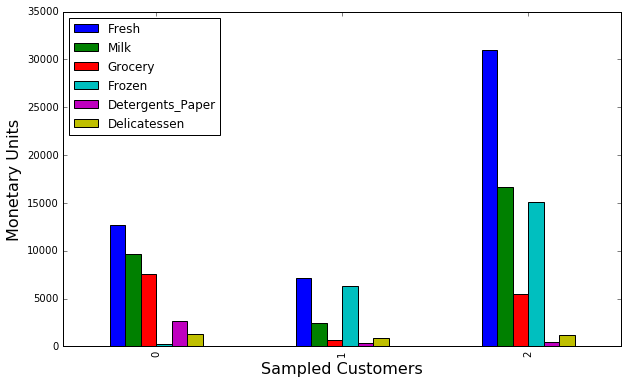

In [5]:
# Plot the feature weights as a function of the components
plt.rcParams['figure.figsize'] = (10, 6)
samples.plot(  kind = 'bar').set_ylabel("Feature Weights")
plt.ylabel('Monetary Units',{'fontsize': 16})
plt.xlabel('Sampled Customers',{'fontsize': 16})


### Figures 2: sample  statistics, product distribution for each sampled customer. 


Consider the total purchase cost of each product category  for the sample customers and the statistical description of the dataset above.  
*We can conclude about the kind of establishment (customer) could each of the three samples you've chosen represent*  


**Customer 0 ** [0] : Monetary units for the 'Fresh', 'Detergents_Paper', 'Grocery' and 'Delicatessen' are around the population average,  'Milk' is above the population average and frozen is bellow the population average. That can be a Hotel since most of the products are around the average. 

**Customer 1 ** [130] : Monetary units for the 'Frozen' is above the population average and 'Fresh', 'Detergents_Paper', 'Grocery', 'Milk' and 'Delicatessen' is bellow the population average. That can be a small caffe. 

**Customer 2 ** [427] : Monetary units for the 'Delicatessen' are around the population average,  'Fresh',  'Milk', 'Frozen' is above the population average and 'Detergents_Paper' is bellow the population average. That can be a Resturant. 


### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, the following is implemented :
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [6]:
# Make a copy of the DataFrame, using the 'drop' function to drop the given feature
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
for item in data.columns :
    new_data = data.copy(deep=True)
    new_data.drop(item, axis =1, inplace = True)

# Split the data into training and testing sets using the given feature as the target
    X_train, X_test, y_train, y_test = train_test_split(new_data ,data[item], test_size = 0.25, random_state=42)

# Create a decision tree regressor and fit it to the training set
    regressor = DecisionTreeRegressor(random_state=0)
    regressor.fit(X_train, y_train)

# Report the score of the prediction using the testing set
    score = regressor.score(X_test, y_test)
    print item , score

Fresh -0.333070533605
Milk 0.173438009379
Grocery 0.699248196675
Frozen -0.278249148824
Detergents_Paper 0.348777454691
Delicatessen -11.0236279005


The coefficients  of determinations list above indicate that ~ 70 % of the variance in 'Grocery' can be explained by the other products in the data set. That signify that 'Grocery' might not be necessary as one of the features in the model, because other features can be used instead. But since 30% of the variance in 'Grocery' cannot be explained, we will use the 'Grocery' hopping that extra information will be useful. 

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data and calculate the correlation values. If we found that 'Grocery' is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if 'Grocery'  is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. 

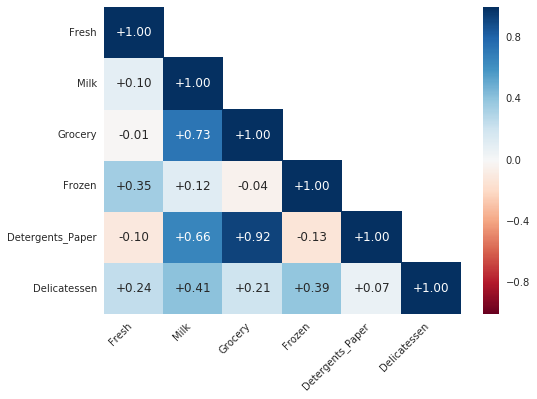

In [7]:
plt.rcParams['figure.figsize'] = (14,8)

import seaborn as sns
import matplotlib.pyplot as plt
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask,  square=False, annot=True, cmap='RdBu', fmt='+.2f')
    plt.xticks(rotation=45, ha='right');

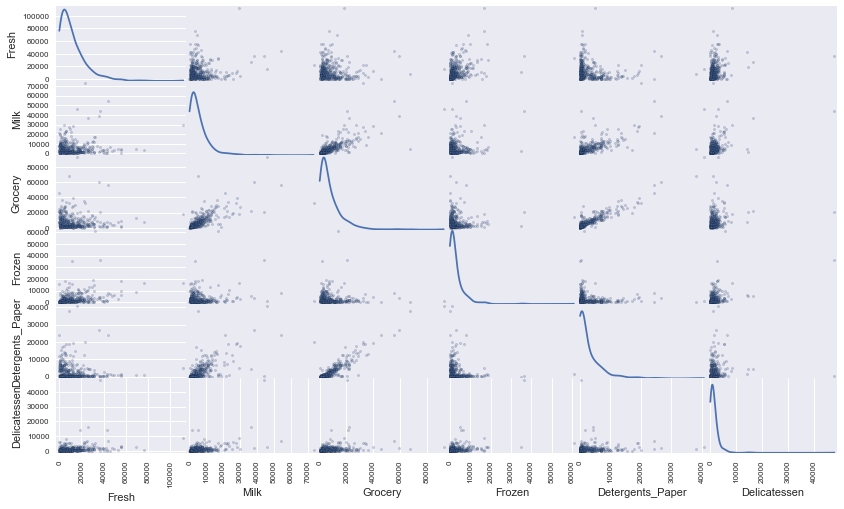

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');


### Figures 3:  We can see that Grocery and milk, detergent paper and grocery have high corelation coefficients.The other relations are quite low other features are lowly corelated. That verify our suspision about the relevance of it when we tried to predict using Decision Tree Regressor algorithm in the previous step. The data for the features is right skewed (positive skewness) which means that most of data happen to be in the first quartile.  

## Data Preprocessing
In this section, I will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that the obtained results from the analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, I implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

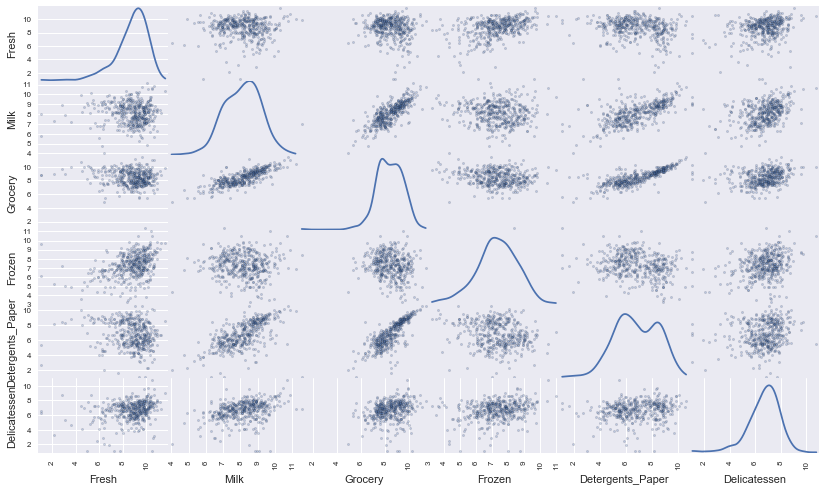

In [9]:
#  Scale the data using the natural logarithm
log_data = np.log(data)
#print log_data.head()
#  Scale the sample data using the natural logarithm
log_samples = np.log(samples)
# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Figures 4 

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature is much more normal. For any pairs of features we have identified earlier Highly corelated features from the original data are still highly corelated after scaling data, and same goes for the lowly corelated features. They are lowly corelated after scaling..



In [10]:
# Display the log-transformed sample data
#print new corelation
print "Corelation between Fresh & Milk:", np.corrcoef(log_data.Fresh, log_data.Milk)[0][1]
print "Corelation between Grocery & Milk:", np.corrcoef(log_data.Grocery, log_data.Milk)[0][1]
print "Corelation between Frozen & Milk:", np.corrcoef(log_data.Frozen, log_data.Milk)[0][1]
print "Corelation between Detergent & Milk:", np.corrcoef(log_data.Detergents_Paper, log_data.Milk)[0][1]
print "Corelation between Delicatessen & Milk:", np.corrcoef(log_data.Delicatessen, log_data.Milk)[0][1]
print "Corelation between Grocery & Milk:", np.corrcoef(log_data.Grocery, log_data.Detergents_Paper)[0][1]
display(log_samples)

Corelation between Fresh & Milk: -0.0198339775013
Corelation between Grocery & Milk: 0.758850896921
Corelation between Frozen & Milk: -0.0553158868051
Corelation between Detergent & Milk: 0.677942424373
Corelation between Delicatessen & Milk: 0.337832531279
Corelation between Grocery & Milk: 0.796397737321


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.874728,7.794823,6.549651,8.750841,5.978886,6.814543
2,10.342130,9.722385,8.599510,9.621257,6.084499,7.058758


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, I  implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.


In [11]:
# For each feature find the data points with extreme high or low values
outliersList=[]
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25);
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75);
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3-Q1)
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])
    outlier = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))].index.tolist()
    
    outliersList+=outlier
    
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers = [65, 66, 75, 128, 154]


# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
#print good_data

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372



There is plenty of outliers for each feature, but only 5 of them appear in more than 2 products [65, 66, 75, 128, 154].  I  remove these outliers, because the clustering analysis that we will use later is sensitive to outliers

## Feature Transformation
In this section I will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, I  will implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

(-0.25, 1)

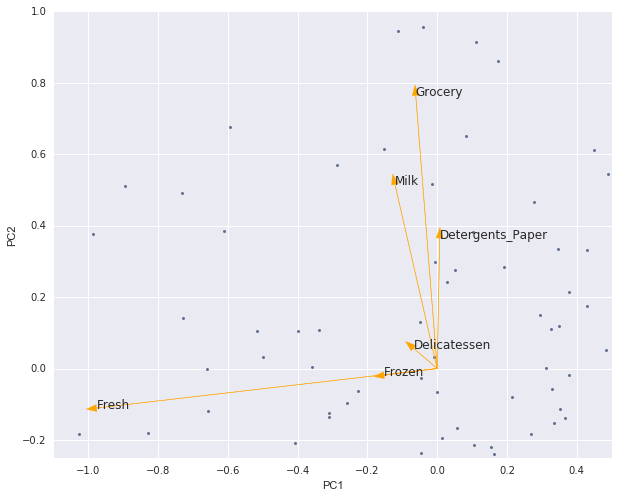

In [12]:

from sklearn.decomposition import PCA

def biplot(df):
    # Fit on 2 components
    pca = PCA(n_components = 2, whiten=True).fit(df)
    
    # Plot transformed/projected data
    ax = pd.DataFrame(
        pca.transform(df),
        columns=['PC1', 'PC2']
    ).plot(kind='scatter', x='PC1', y='PC2', figsize=(10, 8), s=5)

    # Plot arrows and labels
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        ax.arrow(0, 0, pc1, pc2, width=0.001, fc='orange', ec='orange')
        ax.annotate(df.columns[i], (pc1, pc2), size=12)

    return ax

ax = biplot(data)
ax.set_xlim([-1.1, .5])
ax.set_ylim([-.25, 1])

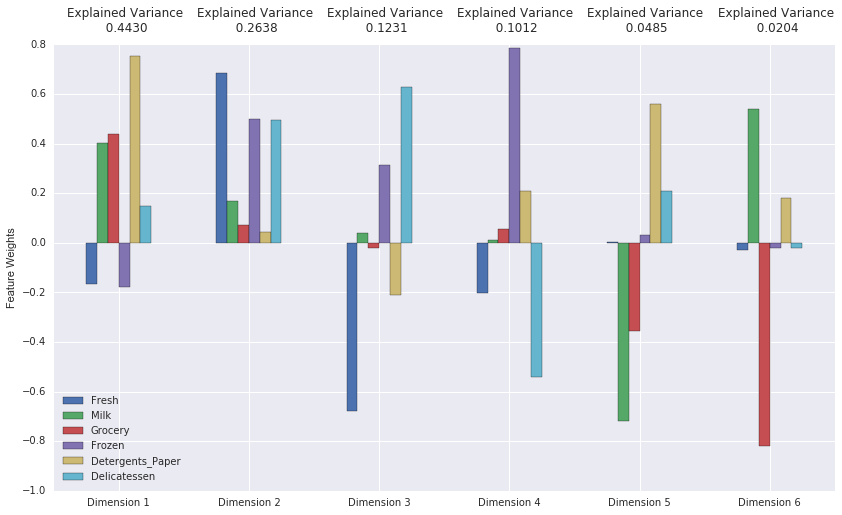

In [13]:
#   Apply PCA to the good data with the same number of dimensions as features
n_components = 6
#  Apply PCA to the good data with the same number of dimensions as features
pca = PCA(n_components=6).fit(good_data)

#  Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Figures 5 : PCA dimenssions

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

From the figure and the analysis here above we can see that the first 2 dimensions explains ~70 % of the variance in the data set, where the first 4 dimensions explains ~90% of the variance. 

**First dimension :** most of the variance in this dimension seems to include the Milk , Grocery and Detergent that are all positives. That is an indication that these 3 products are correlated (as we sow in the correlation analysis). When the consumption of Milk increase, Grocery and Detergent also increase. 

**Second dimension :** most of the variance in this dimension is in the Fresh , Frozen and delicatessen. Interestingly, these are the features that were not expressed in the first dimension.

**Third dimension :** in this dimension we find that the Fresh  and delicatessen have high weights, but with different signs, that indicate that these features are anti correlated. When the  consumption of Fresh  increase, the consumption of Frozen decrease. 

**Forth dimension :** is similar to the Third dimension , but in this case the Groceries and the Milk have different signs

### Observation
The code below demonstrate how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. The numerical value for the first four dimensions of the sample points. 

In [14]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,1.7580,-0.0097,-0.9590,-1.6824,-0.2680,0.3891
1,-1.8415,0.6217,0.6492,0.7504,0.5338,1.2031
2,-0.4545,2.6564,0.0980,1.1628,-1.4384,0.5162


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, I will implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [15]:
# Fit PCA to the good data using only two dimensions
from sklearn.decomposition import PCA
n_components = 2
pca = PCA(n_components=n_components, whiten=True).fit(good_data)

# Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
In the code below we can see that the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions.The values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [16]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,0.8252,-0.0059
1,-0.8644,0.3782
2,-0.2133,1.6159


## Clustering

In this section, I will use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. I will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Gaussian Mixture Model clustering

My choice is to use the Gaussian Mixture Models, the reason for that is the fact that the algorithm maximizes only the likelihood and therefore do not assume any specific structure, where K means have several different assumptions about the structure of the data. In this specific case we cannot assume much about the structure of the data, mainly because we do not know the data. The data include different type of customers that might have different size or buying patterns.
Gaussian Mixture Models:

**Advantages**

1. The fastest algorithm for learning mixture models
2. The algorithm maximizes only the likelihood, therefore it will not bias the means towards zero, or bias the cluster sizes to have specific structures that might or might not apply.

**Disadvantages**
1. When one has insufficiently many points per mixture, estimating the covariance matrices becomes difficult, and the algorithm is known to diverge and find solutions with infinite likelihood unless one regularizes the covariance artificially.
2. This algorithm will always use all the components it has access to, needing held-out data or information theoretical criteria to decide how many components to use in the absence of external cues.


### K Means clustering: 

**Advantages **
1. The problem K means try to solve is computational difficult but there are efficient and fast heuristic algorithms. 
2. Simple to implement and run.
3. Easy to understand, therefore might helps to get a better understanding of the problem. 

**Disadvantages **
1. The Algorithm might convergence to a local minimum that might be wrong result.
2. The numbers of clusters are given as an input, wrong number might cause poor results, and more or less clusters there really are in the data.
3. The algorithm assumes separable, spherical and similar size clusters that are separable, that might cause a failure to classify when data do not satisfy the assumptions.

resource: https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that are expected to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, I will nimplement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [17]:
# Apply your clustering algorithm of choice to the reduced data 
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn import metrics
for  n_component in range(2,3):
    clusters =  GMM(n_components=n_component).fit(reduced_data)
    centroids =clusters.means_

#clusterer = KMeans(n_clusters=2, max_iter=50)
#clusterer.fit(reduced_data)

# Predict the cluster for each data point

    preds = clusters.predict(reduced_data)

# Find the cluster centers
#centers = clusterer.cluster_centers_
   
# Predict the cluster for each transformed sample data point
    sample_preds = clusters.predict(pca_samples)

#  Calculate the mean silhouette coefficient for the number of clusters chosen
    score = metrics.silhouette_score(reduced_data, preds)
    print "n_components:", n_component, "silhouette_score:", score

n_components: 2 silhouette_score: 0.367919613967


n_components: 2 silhouette_score: 0.368046586128

n_components: 3 silhouette_score: 0.340021153984

n_components: 4 silhouette_score: 0.328041604106

n_components: 5 silhouette_score: 0.306857762846

n_components: 6 silhouette_score: 0.268179994695

n_components: 7 silhouette_score: 0.304044733271

n_components: 8 silhouette_score: 0.275592391666

n_components: 9 silhouette_score: 0.304128104375


I tried 2 to 10 clusters. The best score was ~0.37 when the number of clusters was 2 clusters.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

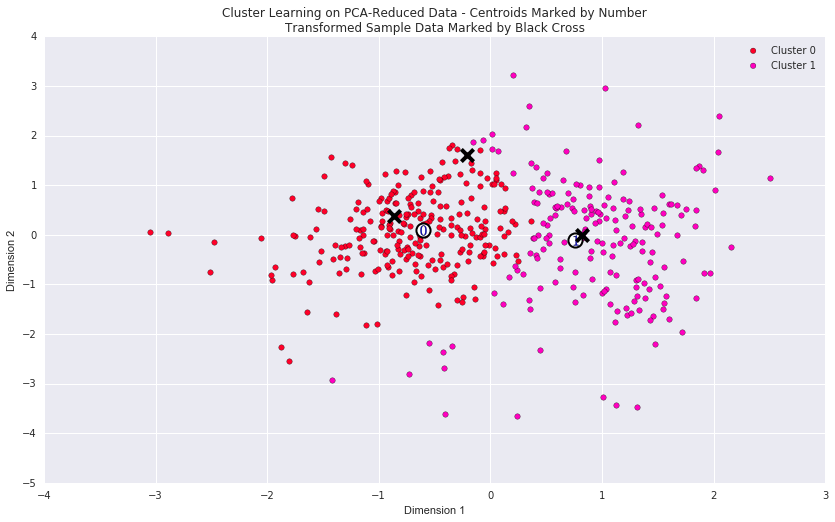

In [18]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centroids, pca_samples)

### Figures 6: Clustering for the cleaned reduced data set

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, I implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [19]:
#   Inverse transform the centers
log_centers = pca.inverse_transform(centroids)

#  Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centroids))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,8779.0,2079.0,2726.0,2049.0,345.0,717.0
Segment 1,4327.0,6266.0,9426.0,1040.0,2976.0,939.0



Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. 

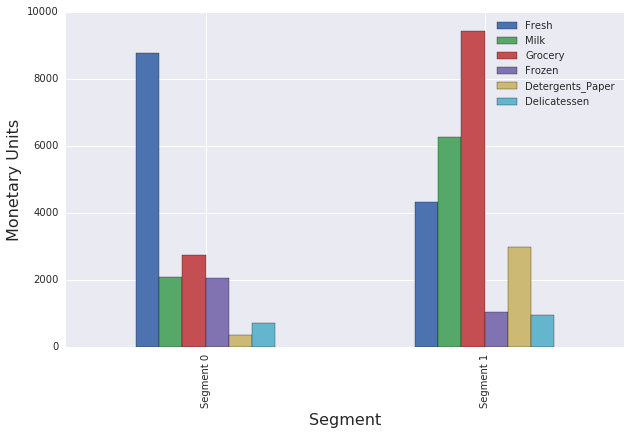

In [20]:
# Plot the feature weights as a function of the components
plt.rcParams['figure.figsize'] = (10, 6)
true_centers.plot(  kind = 'bar');
ax.set_ylabel("Feature Weights")
plt.ylabel('Monetary Units',{'fontsize': 16})
plt.xlabel('Segment',{'fontsize': 16})

### Figures 7: Product distribution for the 2 clusters (or segments) that were identified by the analysis. 

**For Segment 1** we find that Milk	Grocery and	Detergents_Paper are above the population average and the other products are below. This segment might  represents hotels. 

**For Segment 0** All products are bellow the population average but the Fresh products are high compared to the others. Represents coffee or resturant. 

### Assign the sampled customer to a specific cluster segment. 
For each sampled customer we now can assign a segment that best represents it. 

The code block below find which cluster each sample point is predicted to be.

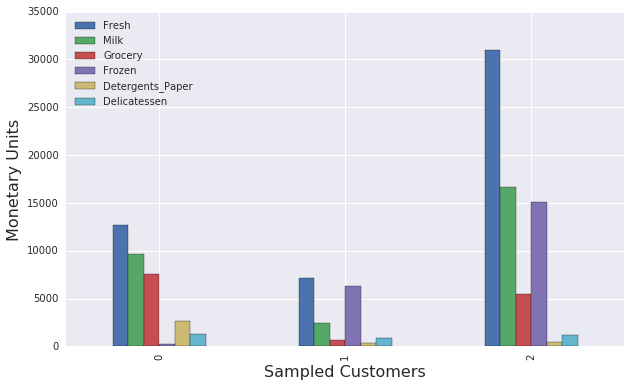

In [21]:
# Plot the feature weights as a function of the components
plt.rcParams['figure.figsize'] = (10, 6)
samples.plot(  kind = 'bar');
ax.set_ylabel("Feature Weights")
plt.ylabel('Monetary Units',{'fontsize': 16})
plt.xlabel('Sampled Customers',{'fontsize': 16})

### Figures 8: Product distribution for the 3 sampled customers. 

In [22]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**Customer 0 [0] :** Monetary units for the 'Fresh', 'Detergents_Paper', 'Grocery' and 'Delicatessen' are around the population average, **'Milk' is above the population average** and frozen is bellow the population average. That can be a Hotel since most of the products are around the average.

**For Segment 1 ** we find that **Milk Grocery and Detergents_Paper are above the population average** and the other products are below. This segment might represents hotels.

**Customer 1 [130] :** Monetary units for the **'Frozen' is above the population average and 'Fresh'**, 'Detergents_Paper', 'Grocery', 'Milk' and 'Delicatessen' is bellow the population average. That can be a small caffe.
**Customer 2 [427] :** Monetary units for the 'Delicatessen' are around the population average,** 'Fresh', 'Milk', 'Frozen' is above the population average** and 'Detergents_Paper' is bellow the population average. That can be a Resturant.

**For Segment 0** All products are bellow the population average but **the Fresh products are high compared to the others**. Represents coffee or resturant. 




## Conclusion

### A/B test
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. The wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, below I describe a simple A/B test that can used to appriciate which type of customers might appriciate this change.

The classification reveals additional information about the data set. The buyers does not distribute homogeneously, instead there are different patterns of buying. Fortunately enough we could detect these patterns and labels each client accordingly. One way for a new experiment will be to choose a 'test group' within each label, for example 20% from each class. For this 'test group' we can change small number of features, for example delivery time. That will enable us to compare the response to the change in the 'test group' and separately in the control group (the other 80%). The results can be different in each class, but then we can decide for each class if the change is beneficial or not. 

 ###   predictive model 
*Assume the wholesale distributor wanted to predict a new feature for each customer based on the purchasing information available. Bellow is a description of a simple predictive model that can be useful in this case*  


For prediction it is important to have some labels, this data does not include labeling. Other than the customer ID we do not really know what class or type is each customer. One way to overcome this will be to use as labels from the clustering analysis. Obviously the edges of the clusters might be problematic and might introduce error to the training. However, we can choose data points (or customers) that are closer to the center of each cluster and remove the data points on the edges. The training on these groups will provide us with a model. The model can be tested on a separate test sample (that will not be used for the training procedure).If the model performance is high enough we can use this model for prediction.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

The code block below demonstrate how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, the sampled customers are circled in the plot, which will identify their labeling.

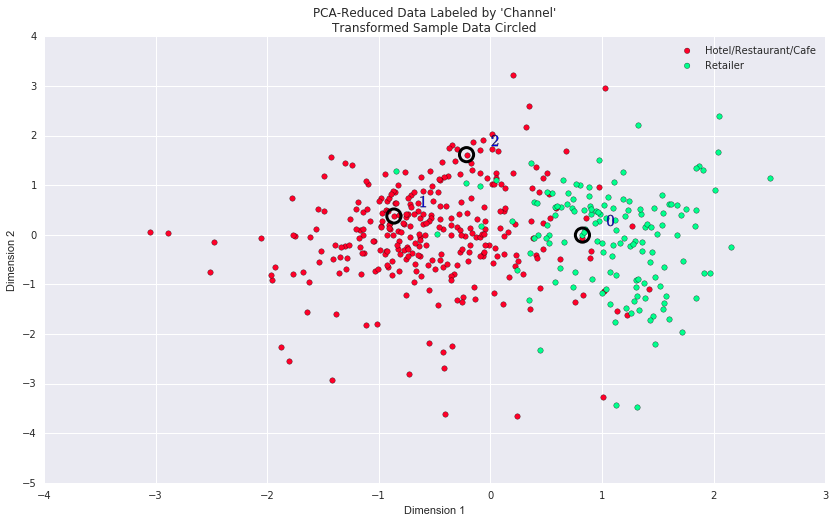

In [23]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Figure 9 : Comparison of the clasification performed by the analysis (the location in the PCA space)  and the actual labeling in the data set (different collors). 